In [1]:
#Control time packages
import time
import os

os.environ["OMP_NUM_THREADS"] = "1"


import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy
import dark_mge                                   #My mge1d_fit for DM 


from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

from schwimmbad import MPIPool
"""
We will use one beta for gaussian in MGE, except for the two first. AS it have sigma < pixscale, we will use the same beta for both.

"""
boundary = {"ml0": [0.5, 15], "delta": [0.1, 2], "lower": [0, 1],  "qinc": [0.051, 0.468808],
             "beta0": [-3, 3],"beta1": [-3, 3],"beta2": [-3, 3],"beta3": [-3, 3],"beta4": [-3, 3],"beta5": [-3, 3],"beta6": [-3, 3],"beta7": [-3, 3], "log_mbh": [7, 11],
             "kappa_s": [0, 2.0], "rs": [2.0, 50], "qDM": [0.1, 1]}

def gaussian_ml(sigma, delta, ml0=1.0, lower=0.4):
    """
    Create a M*L gradient
    Input:
    -----------
        sigma: Gaussian sigma                           [arcsec]
        delta: Gradient value
        ml0: Central stellar mass to light ratio        [M_sun/L_sun]    
        lower: the ratio between the central and the outer most M/L
    Output:
    ----------
        ML: gaussian mass to light ratio. One component per gaussian in surf_lum.
    """

    sigma = np.atleast_1d(sigma)
    sigma = sigma - sigma[0]
    ML = ml0 * (lower + (1-lower)*np.exp(-0.5 * (sigma * delta)**2))
    
    return ML


class Model(object):
    def __init__(self, Jam_model, NFW):
        self.Jam_model = Jam_model
        self.NFW = NFW


    def prior_transform(self, theta):
        (ml0, delta, lower, qinc, beta0,beta1,beta2,
                    beta3,beta4,beta5,beta6,beta7, log_mbh,kappa_s, rs, qDM) = theta
        parsDic = {"ml0":ml0, "delta": delta, "lower": lower, "qinc":qinc, 
                    "beta0":beta0,"beta1":beta1,"beta2":beta2,"beta3":beta3,"beta4":beta4,  "beta5":beta5,"beta6":beta6,"beta7":beta7,"log_mbh":log_mbh,
                    "kappa_s": kappa_s, "rs": rs, "qDM": qDM}
        for key in parsDic:
            parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
        
        return np.array(list(parsDic.values()))

    def log_likelihood(self, theta):
        (ml0, delta, lower, qinc, beta0,beta1,beta2,
                    beta3,beta4,beta5,beta6,beta7, log_mbh,kappa_s, rs, qDM) = theta

        # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
        qmin = np.min(self.Jam_model.qobs_lum)
        inc_model = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 -qinc**2))))

        qdm_proj      = np.sqrt( (np.sin(np.radians(inc_model)) * qDM )**2  + np.cos( np.radians(inc_model))**2     )     #Projected DM axial ratio
        qDM_model     = np.ones_like(self.Jam_model.qobs_dm)*qdm_proj

        surf_dm_model, sigma_dm_model = self.NFW.fit(kappa_s,rs,ngauss=15,outer_slope=2, quiet=True)

        beta_model  = np.array([beta0,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7])
        ml_model    = gaussian_ml(sigma=self.Jam_model.sigma_lum, ml0=ml0, delta=delta, lower=lower)
        mbh_model   = 10**log_mbh
        
        self.Jam_model.upt(inc=inc_model, ml=ml_model, beta=beta_model, mbh=mbh_model,
                            surf_dm=surf_dm_model, sigma_dm=sigma_dm_model, qobs_dm=qDM_model)
        
        rmsModel, ml, chi2, chi2T = self.Jam_model.run(quiet=True, plot=False)
        
        
        return -0.5 * chi2T

    def __call__(self, pars):
        return self.log_likelihood(pars)

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz

Critical Density:2.165e+03 solMass / pc2
At Redshift 0.299, your dark matter halo goes from 2.747e-04 arcsec to 2.182e+02 arcsec:
The scale radius are 4.583e+03 pc
Iteration: 1  chi2: 0.2797 Nonzero: 15/15
Iteration: 11  chi2: 0.1256 Nonzero: 15/15
Iteration: 21  chi2: 0.1102 Nonzero: 15/15
Iteration: 31  chi2: 0.1091 Nonzero: 15/15
Iteration: 35  chi2: 0.1091 Nonzero: 15/15
############################################
 Computation time: 0.34 seconds
 Total Iterations:  35
Nonzero Gaussians:  15
 Unused Gaussians:  0
 Chi2: 0.1091 
 STDEV: 0.02335
 MEANABSDEV: 0.0208
############################################
 Total_Counts      Sigma
############################################
      358.297      1.30267
      354.952      3.90295
       353.43      11.6223
      351.381      34.4364
      346.001      101.043
      329.757       288.93
       284.92      779.208
      194.782      1924.69
      93.6669      4411.92
      32.5329      9711.81
      9.09761      20991.1
       2.2561 

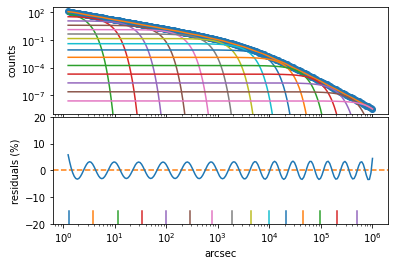

Testing Inputs...
Likelihood Value: -82771.17224833232


In [2]:
# Reading Data
x, y, vrms, erms              = np.loadtxt("Input/Vrms_map_rot.txt", unpack=True)           #vrms data
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)              #MGE decomposition
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True)         #PSF

# Defing some inputs
z_l     = 0.299                                                         #Redshift of lens
z_s     = 3.042                                                         #Redshift of source
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, -0.15)                                 #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
ml      = gaussian_ml(sigma_lum, delta=0.5, ml0=7.0, lower=0.4)         #mass to light ratio
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                        (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)   #Deprojected axial ratio for inclination

pixsize = 0.2    #MUSE pixel size

# Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms, normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)
#Add DM component
    #First initialize the NFW class. We are giving random numbers, because they will be updates during the fit. 
NFW = dark_mge.NFW(z_l=z_l, z_s=z_s, r_min=0.1, r_max=6.0, nsample=200, quiet=False)
surf_dm, sigma_dm = NFW.fit(kappa_s=0.075,rs=1.0,ngauss=15,outer_slope=2, quiet=False)

Jam_model.DM_component(surf_dm=surf_dm, sigma_dm=sigma_dm, qobs_dm=np.ones_like(sigma_dm))

model = Model(Jam_model=Jam_model, NFW=NFW)

print("Testing Inputs...")
#ML0, delta, lower, qinc, beta, log_mbh, kappa_s, rs, qDM
p0 = np.array([7.0, 0.5, 0.4, qinc, beta[0], beta[0], beta[0], beta[0], beta[0], beta[0], beta[0], beta[0], np.log10(mbh), 1.0, 18, 0.85])
print("Likelihood Value:", model(p0))

In [3]:
import pickle
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

with open(f'jam_gaussianML_noDM_MultiBeta.pickle','rb') as f:
    sample_load = pickle.load(f)

In [4]:
results = sample_load.results
results.summary()

Summary
nlive: 150
niter: 2000
ncall: 42683
eff(%):  5.037
logz: -464.383 +/-  0.864


In [5]:
resume_dlogz(sample_load)

0.5547863335858665

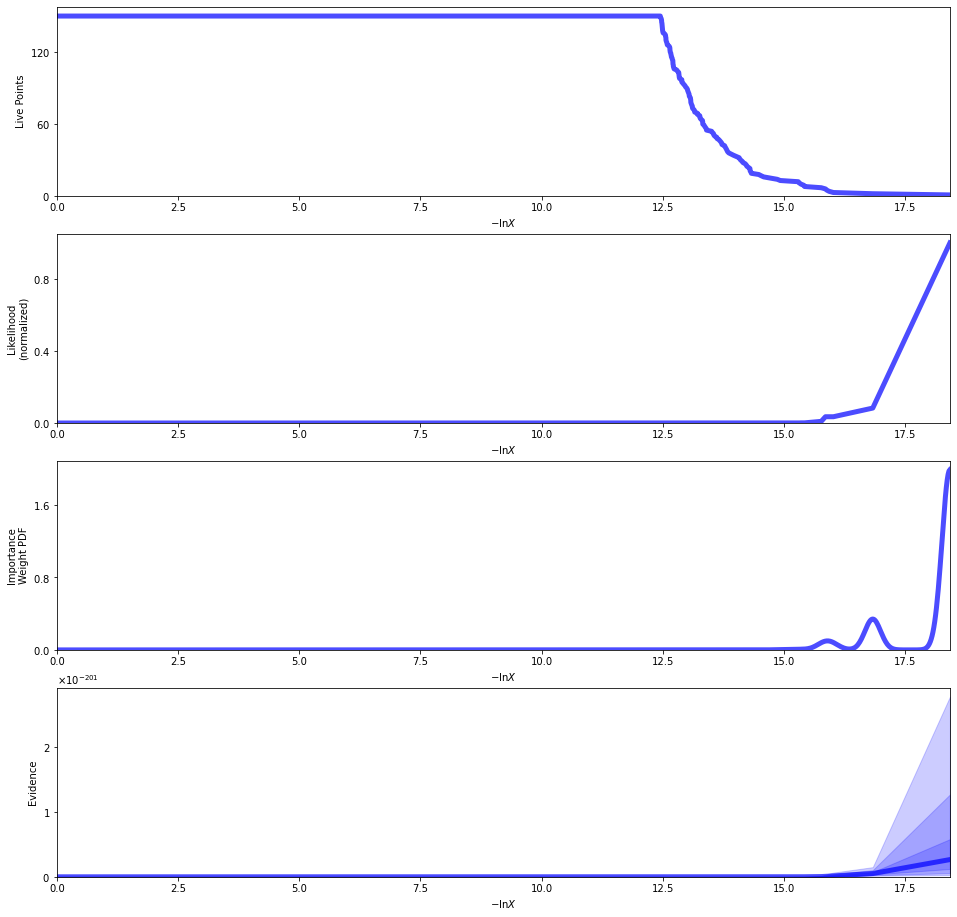

In [6]:
fig, axes = dyplot.runplot(dyfunc.simulate_run(sample_load.results))

In [7]:
# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sample_load.results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

(array([ 3.47322313,  1.02725186,  0.52919744,  0.21321834,  1.18716867,
         0.30069989,  0.46221775,  1.18635521, -0.15272064, -0.09695533,
        -0.31117672,  0.22242   ,  8.03764385,  0.1437656 , 33.47875858,
         0.60951907]),
 array([[ 1.77245272e-01, -2.30080795e-01, -1.15929531e-01,
          2.44132257e-02,  4.48915111e-01, -3.31872206e-01,
          3.97302104e-02, -3.45338097e-01, -1.84963054e-01,
          6.28984209e-01, -2.16061823e-01,  1.19029127e-01,
          4.08077042e-02, -2.04834922e-02,  3.98266651e+00,
         -7.05172922e-02],
        [-2.30080795e-01,  6.87418559e-01,  2.69015292e-01,
         -4.66059125e-02, -1.38935187e+00,  1.74216518e+00,
         -4.99063800e-02,  7.67229065e-01,  4.61901579e-01,
         -1.21251121e+00, -7.86777899e-02, -3.35522348e-01,
         -6.22162196e-01,  4.31188530e-02, -6.94965690e+00,
          2.53717430e-01],
        [-1.15929531e-01,  2.69015292e-01,  1.20555041e-01,
         -2.03713602e-02, -4.88366580e-01,  

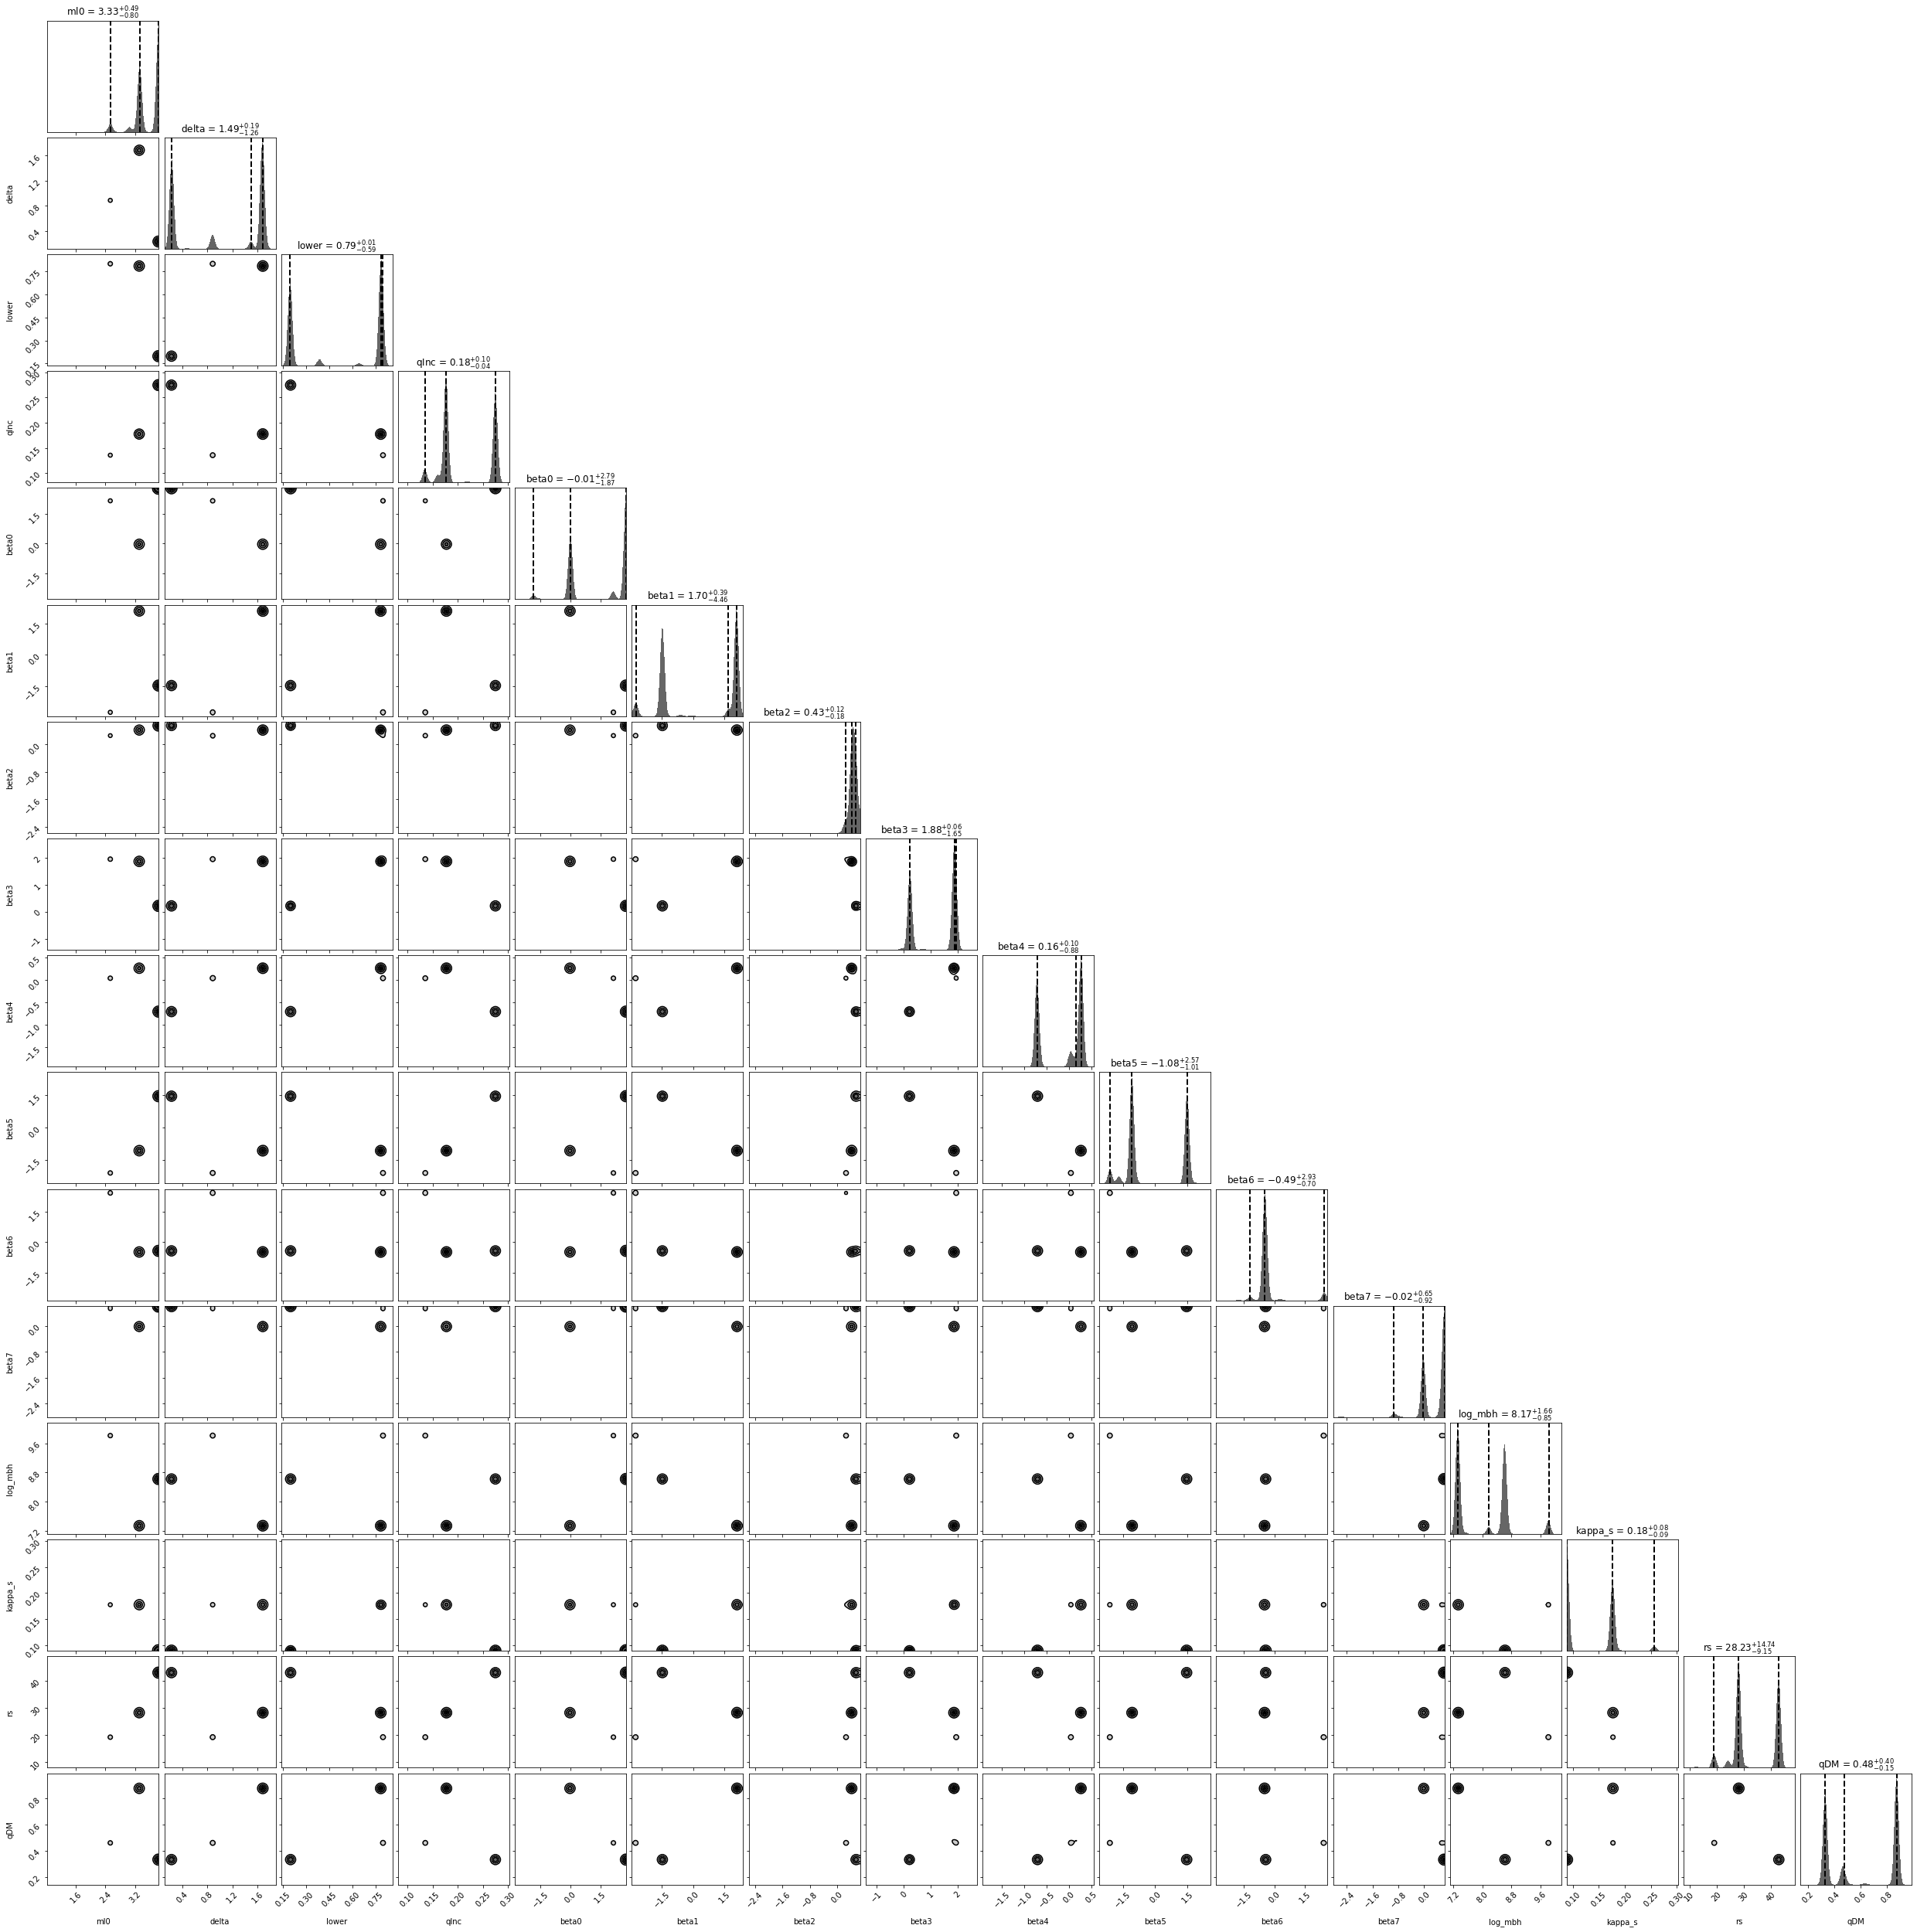

In [8]:
labels = ["ml0", "delta", "lower", "qInc", "beta0","beta1","beta2","beta3","beta4",
              "beta5","beta6","beta7", "log_mbh", "kappa_s", "rs", "qDM"]
cfig, caxes = dyplot.cornerplot(results_sim,show_titles=True,labels=labels,
                               )

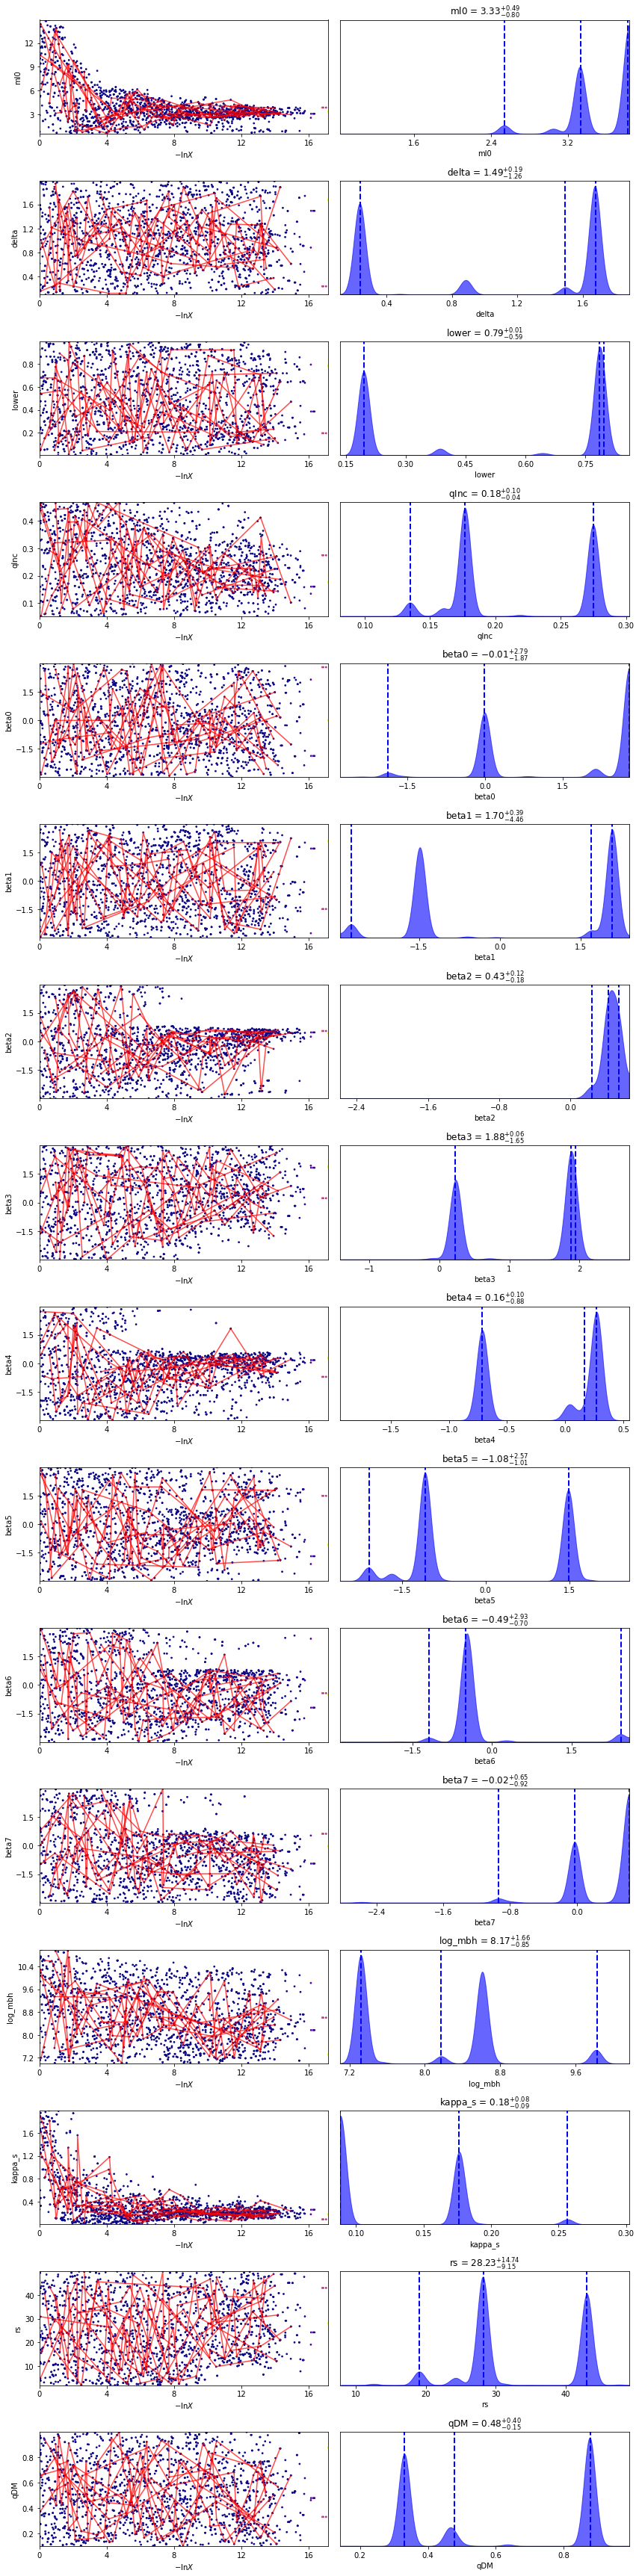

In [9]:
labels = ["ml0", "delta", "lower", "qInc", "beta0","beta1","beta2","beta3","beta4",
              "beta5","beta6","beta7", "log_mbh", "kappa_s", "rs", "qDM"]
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,
                               show_titles=True, connect=True,)
plt.tight_layout()

In [10]:
model(mean)
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

jam_axi_rms elapsed time sec: 0.39
inc=64.7 beta_z=1.19 M/L=1 BH=1.09e+08 chi2/DOF=3.35
Total mass MGE: 9.102e+13


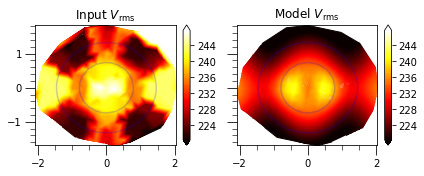

In [11]:
vrmsModel, a, b, c = Jam_model.run(plot=True, quiet=False)
plt.tight_layout()

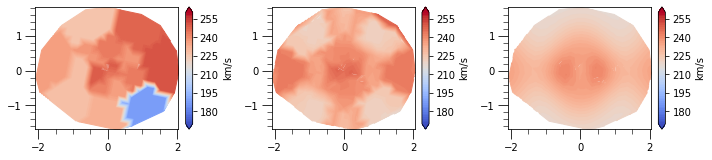

In [12]:
from plotbin.symmetrize_velfield import symmetrize_velfield

sym = symmetrize_velfield(xbin=x,ybin=y,vel_bin=vrms,sym=2)


plt.figure(figsize=(10,8))
plt.subplot(131)
plot_velfield(x=x*pixsize, y=y*pixsize, vel=vrms, colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)

plt.subplot(132)
plot_velfield(x=x*pixsize, y=y*pixsize, vel=sym, colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)

plt.subplot(133)

plot_velfield(x=x*pixsize, y=y*pixsize, vel=vrmsModel,colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)


plt.tight_layout()

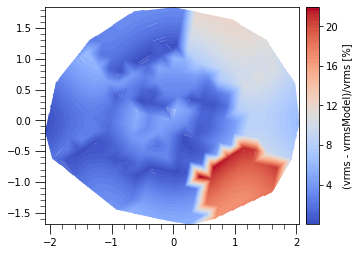

In [13]:
plot_velfield(x=x*pixsize, y=y*pixsize, vel=100*abs((vrms - vrmsModel)/vrms),colorbar=True,label='(vrms - vrmsModel)/vrms [%]', cmap=plt.cm.coolwarm, nodots=True)


In [14]:
from jampy import mge_radial_mass                                   #Compute mass inside some radius


In [15]:
help(mge_radial_mass.mge_radial_mass)

Help on function mge_radial_mass in module jampy.mge_radial_mass:

mge_radial_mass(surf, sigma, qobs, inc, rad, distance=1e-05)
    Calculates the analytic mass or luminosity of an axisymmetric
    MGE within a sphere of a given radius, using equation (14) of
    `Mitzkus, Cappellari & Walcher, 2017, MNRAS, 464, 4789
    <https://ui.adsabs.harvard.edu/abs/2017MNRAS.464.4789M>`_
    
    :param surf: Peak surface brightness of each Gaussian in Lsun/pc**2
    :param sigma: Gaussian dispersion in arcsec
    :param qobs: Observed axial ratio of each Gaussian
    :param inc: inclination of the MGE in degrees
    :param rad: radius of the sphere in arcsec (scalar or vector)
    :param distance: Galaxy distance in Mpc
    :return: mass of the MGE within spheres of radii rad (same size as rad)



In [16]:
pc = Jam_model.distance*np.pi/0.648 # Constant factor to convert arcsec --> pc (with distance in Mpc)
sigmaBH_pc = Jam_model.rbh*pc # Adopt for the BH just a very small size
surfBH_pc = Jam_model.mbh/(2*np.pi*sigmaBH_pc**2)
qobs_bh = np.array([1])  # Make sure vectors do not have extra dimensions


In [36]:
total_mass = mge_radial_mass.mge_radial_mass(surf=np.concatenate((Jam_model.surf_lum*Jam_model.ml, Jam_model.surf_dm, surfBH_pc), axis=None),
                             sigma=np.concatenate((Jam_model.sigma_lum, Jam_model.sigma_dm, Jam_model.rbh), axis=None),
                             qobs=np.concatenate((Jam_model.qobs_lum, Jam_model.qobs_dm, qobs_bh), axis=None),
                             inc=Jam_model.inc, rad=1.0, distance=Jam_model.distance)

In [37]:
total_mass

array([1.35601304e+11])

In [38]:
dark_mass =  mge_radial_mass.mge_radial_mass(surf= Jam_model.surf_dm/0.42895935,
                             sigma=Jam_model.sigma_dm,
                             qobs= Jam_model.qobs_dm,
                             inc=Jam_model.inc, rad=1.0, distance=Jam_model.distance)
dark_mass

array([8.69161836e+10])

In [39]:
dark_mass/total_mass

array([0.64096864])

In [21]:
Jam_model.surf_dm

array([626.95163013, 619.60188288, 616.84724919, 615.15314492,
       614.33976003, 614.12666547, 613.87259452, 612.03821555,
       604.83775676, 582.9209075 , 524.86217157, 401.56223273,
       233.94422888, 104.32639028,  40.43904922])

In [22]:
mean

array([ 3.47322313,  1.02725186,  0.52919744,  0.21321834,  1.18716867,
        0.30069989,  0.46221775,  1.18635521, -0.15272064, -0.09695533,
       -0.31117672,  0.22242   ,  8.03764385,  0.1437656 , 33.47875858,
        0.60951907])